Ovo je druga obavezna bilježnica u okviru kolegija Dubinska analiza podataka. Cilj ove bilježnice je raditi sa značajkama train skuoa te stvoriti nove značajke koje će pridonjeti kvaliteti skupa podataka.

In [7]:
import numpy as np
import pandas as pd

# 0. Priprema skupa podataka

Ovdje ću pripremiti train i test skup nad kojima ću onda obavljati zadatke.

In [5]:
train=pd.read_csv("/kaggle/input/dapprojekt23/train.csv")
del train["id"]
train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})
train=train.loc[train['day']>365]
train.total.abs()
train.broken.abs()
train=train.loc[train['broken']<train['total']]

In [43]:
test=pd.read_csv("/kaggle/input/dapprojekt23/test.csv")
del test["id"]
test=test.astype({"machine_name":"category"})
test=test.astype({"day":"uint16"})
test=test.astype({"broken":"uint16"})
test=test.astype({"total":"uint16"})
test.total.abs()
test.broken.abs()

0          0
1          3
2          0
3          6
4          0
          ..
923266    12
923267    12
923268     8
923269    17
923270    14
Name: broken, Length: 923271, dtype: uint16

In [45]:
test=test.astype({"machine_name":"category"})
test=test.astype({"day":"uint16"})
test=test.astype({"broken":"uint16"})
test=test.astype({"total":"uint16"})
test.dtypes

machine_name    category
day               uint16
broken            uint16
total             uint16
dtype: object

In [12]:
for machine in train.machine_name.unique():
    anomaly_day=pom=train[(train['machine_name'] == machine) & (train['label'] == 1)].day.min()
    pom = train[(train['machine_name'] == machine) & (train['label'] == 1) 
                & (train['day']>anomaly_day)].index
    train.drop(pom , inplace=True)

In [13]:
strojevi=train.machine_name.unique()
data_to_be_appended=pd.DataFrame(columns=['day', 'broken', 'total', 'label', 'machine_name'])

i=1
for stroj in strojevi:
    dani=range(366,train.loc[train['machine_name']==stroj].day.max()+1)
    stroj_dani=train.loc[train['machine_name']==stroj].day.unique()
    dani_bez_podataka=np.setdiff1d(np.asarray(dani), np.asarray(stroj_dani))
    machine_data=train.loc[(train['machine_name']==stroj)]
    i+=1
    for dan in dani_bez_podataka:
        
        total=abs(int(np.random.normal(loc=machine_data.loc[machine_data['label']==0].total.mean(),
                                       scale=machine_data.loc[machine_data['label']==0].total.std())))
        broken=abs(int(np.random.normal(loc=machine_data.loc[machine_data['label']==0].broken.mean(),
                                        scale=machine_data.loc[machine_data['label']==0].broken.std())))
        
        while broken>=total:
            total=abs(int(np.random.normal(loc=machine_data.loc[machine_data['label']==0].total.mean(),
                                       scale=machine_data.loc[machine_data['label']==0].total.std())))
            broken=abs(int(np.random.normal(loc=machine_data.loc[machine_data['label']==0].broken.mean(),
                                        scale=machine_data.loc[machine_data['label']==0].broken.std())))
        
        
        day_before=machine_data.loc[(machine_data['day']==dan-1)]
        day_after=machine_data.loc[(machine_data['day']==dan+1)]

        if day_before.empty or day_after.empty or day_before.label.sum()!=day_after.label.sum():
            novi_red = {'day':dan, 'broken':broken,
                        'total':total, 'label':0, 
                        'machine_name':stroj}
            data_to_be_appended=data_to_be_appended.append(novi_red, ignore_index=True)
        else:
            broken=int((day_before.broken.sum()+day_after.broken.sum())/2)
            total=int((day_before.total.sum()+day_after.total.sum())/2)

            novi_red = {'day':dan, 'broken':broken,
                        'total':total, 'label':day_before.label.sum(), 
                        'machine_name':stroj}
            data_to_be_appended=data_to_be_appended.append(novi_red, ignore_index=True)

In [14]:
train=train.append(data_to_be_appended, ignore_index=True)

In [15]:
train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})
train.dtypes

day               uint16
broken            uint16
total             uint16
label              uint8
machine_name    category
dtype: object

Sad ću spremiti oba dataseta nakon napravljenih promjena i onda ću i kasnije koristiti u ostalim zadatcima.

In [20]:
train.to_csv('train_fixed.csv', index=False)
test.to_csv('test_fixed.csv', index=False)

# 1. Cross-validation function 1
 Ovdje ću sada stvoriti prvu cross validation funkciju koja će koristiti GaussianNB, LogisticRegression, RIPPER, RandomForestClassifier, ExtraTreesClassifier i XGBClassifier modele.

In [8]:
train=pd.read_csv("/kaggle/input/fixed-data-new/train_fixed_new.csv")

In [9]:
!pip install Wittgenstein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.6/110.6 kB 3.9 MB/s eta 0:00:00


In [120]:
import wittgenstein as lw
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from itertools import combinations
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import norm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import shap 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [11]:
def gaussNB(train_x, train_y, test_x, test_y):
    clf = GaussianNB()
    clf.fit(train_x,train_y)
    y_pred=clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

def logReg(train_x, train_y, test_x, test_y):
    clf = LogisticRegression(random_state=0).fit(train_x, train_y)
    y_pred=clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

def ripper(train_x, train_y, test_x, test_y):
    ripper_clf = lw.RIPPER()
    ripper_clf.fit(train_x, train_y)
    y_pred=ripper_clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

def RFC(train_x, train_y, test_x, test_y):
    clf = RandomForestClassifier()
    clf.fit(train_x, train_y)
    y_pred=clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

def ETC(train_x, train_y, test_x, test_y):
    clf = ExtraTreesClassifier()
    clf.fit(train_x, train_y)
    y_pred=clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

def XGB(train_x, train_y, test_x, test_y):
    clf=XGBClassifier()
    clf.fit(train_x, train_y)
    y_pred=clf.predict(test_x)
    return f1_score(test_y, y_pred, average='macro')

In [12]:
def cross_validation_1(data, num_folds):
    data=data.drop(["machine_name", "day"], axis=1)
    pom=data
    folds=[]
    sample_size=int(len(data)/num_folds)
    for i in range(1, num_folds):
        folds.append(pom.iloc[:sample_size])
        pom = pom.iloc[sample_size:]
    folds.append(pom)
    
    gaussianNB_f1=[]
    logReg_f1=[]
    ripper_f1=[]
    RFC_f1=[]
    ETC_f1=[]
    XGB_f1=[]
    for fold in folds:
        train=pd.concat([data, fold, fold]).drop_duplicates(keep=False)
        train_x=train.drop(["label"], axis=1)
        train_y=train["label"]
        train_x=np.asarray(train_x)
        train_y=np.asarray(train_y)
        
        test_x=fold.drop(["label"], axis=1)
        test_y=fold["label"]
        test_x=np.asarray(test_x)
        test_y=np.asarray(test_y)
        
        gaussianNB_f1.append(gaussNB(train_x, train_y, test_x, test_y))
        logReg_f1.append(logReg(train_x, train_y, test_x, test_y))
        ripper_f1.append(ripper(train_x, train_y, test_x, test_y))
        RFC_f1.append(RFC(train_x, train_y, test_x, test_y))
        ETC_f1.append(ETC(train_x, train_y, test_x, test_y))
        XGB_f1.append(XGB(train_x, train_y, test_x, test_y))
        
    gaussianNB_f1.append(np.mean(gaussianNB_f1))
    logReg_f1.append(np.mean(logReg_f1))
    ripper_f1.append(np.mean(ripper_f1))
    RFC_f1.append(np.mean(RFC_f1))
    ETC_f1.append(np.mean(ETC_f1))
    XGB_f1.append(np.mean(XGB_f1))
    
    results=pd.DataFrame(columns=['algorithm', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', ' Fold 5', 'average'])
    results.loc[len(results)] = np.append(['Gaussian_NB'], gaussianNB_f1)
    results.loc[len(results)] = np.append(['LogisticRegresion'],logReg_f1)
    results.loc[len(results)] = np.append(['RIPPER'],ripper_f1)
    results.loc[len(results)] = np.append(['RandomForrestClassifier'],RFC_f1)
    results.loc[len(results)] = np.append(['ExtraTreesClassifier'],ETC_f1)
    results.loc[len(results)] = np.append(['XGBClassifier'],XGB_f1)
    
    return results

# 2. Run the cross-validation function 1

In [37]:
results=cross_validation_1(train, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.6686300526172412,0.563306467177129,0.6023162382352417,0.5123196656620639,0.49968748542376046,0.5692519818230872
1,LogisticRegresion,0.5170305317912867,0.5193493732754669,0.5249665737230548,0.49992540236101535,0.4999813533722426,0.5122506469046133
2,RIPPER,0.5044025884424638,0.4976262416260706,0.5045198778959695,0.4925526039567942,0.4914630969655195,0.49811288177736357
3,RandomForrestClassifier,0.4995007046131161,0.49946800567460614,0.4996874737617897,0.49994871651421485,0.49998601515956703,0.4997181831446588
4,ExtraTreesClassifier,0.5085869332817479,0.5100923973661373,0.4996874737617897,0.4999347282831674,0.4999813533722426,0.5036565772130169
5,XGBClassifier,0.5084152531525742,0.5385574536989998,0.5402233290164324,0.4999207392694958,0.49997669149799084,0.5174186933270987


Najbolji model je gaussianNB s prosjecnim f1 rezultatom od 0.56925

In [39]:
test=pd.read_csv("/kaggle/input/fixed-data_new/test_fixed_new.csv")

In [162]:
def submit(X, X_test, clf):
    y=list(X['label'])
    X=X.drop(["label", "machine_name"], axis=1)
    
    X=np.asarray(X)
    X_test=X_test.drop(["machine_name"], axis=1)
    X_test=np.asarray(X_test)
    clf.fit(X,y)
    y_pred=clf.predict(X_test)

    submission=pd.read_csv("/kaggle/input/dapprojekt23/test.csv")
    submission['Predicted']=y_pred
    del submission['day']
    del submission['broken']
    del submission['total']
    del submission['machine_name']
    submission=submission.astype({"Predicted":"uint8"})
    submission.to_csv('submission.csv',index=False)

In [ ]:
clf=GaussianNB()
submit(train, test, clf)

Rezultat nad test skupom je 0.49957.

# 3. Cross-validation function 2

Ovdje će podjela na grupe biti izvršena pazeći na imena mašina tako da su svi podatci za jednu mašinu u istoj grupi,a zatim će se provesti cross validacija.

In [5]:
def cross_validation_2(data, num_folds):
    num_of_machines=len(data.machine_name.unique())
    
    pom=data
    folds=[]
    for i in range(1, num_folds):
        fold = pom.loc[pom['machine_name'].isin(pom.machine_name.unique()[:int(num_of_machines/num_folds)])]
        fold=fold.drop(["machine_name"], axis=1)
        folds.append(fold)
        pom = pom.loc[pom['machine_name'].isin(pom.machine_name.unique()[int(num_of_machines/num_folds):])]
    
    pom=pom.drop(["machine_name"], axis=1)
    folds.append(pom)
    gaussianNB_f1=[]
    logReg_f1=[]
    ripper_f1=[]
    RFC_f1=[]
    ETC_f1=[]
    XGB_f1=[]
    
    data=data.drop(["machine_name"], axis=1)
    for fold in folds:
        train=pd.concat([data, fold, fold]).drop_duplicates(keep=False)
        train_x=train.drop(["label", "day"], axis=1)
        train_y=train["label"]
        train_x=np.asarray(train_x)
        train_y=np.asarray(train_y)
        
        test_x=fold.drop(["label", "day"], axis=1)
        test_y=fold["label"]
        test_x=np.asarray(test_x)
        test_y=np.asarray(test_y)
        
        gaussianNB_f1.append(gaussNB(train_x, train_y, test_x, test_y))
        logReg_f1.append(logReg(train_x, train_y, test_x, test_y))
        ripper_f1.append(ripper(train_x, train_y, test_x, test_y))
        RFC_f1.append(RFC(train_x, train_y, test_x, test_y))
        ETC_f1.append(ETC(train_x, train_y, test_x, test_y))
        XGB_f1.append(XGB(train_x, train_y, test_x, test_y))
        
    gaussianNB_f1.append(np.mean(gaussianNB_f1))
    logReg_f1.append(np.mean(logReg_f1))
    ripper_f1.append(np.mean(ripper_f1))
    RFC_f1.append(np.mean(RFC_f1))
    ETC_f1.append(np.mean(ETC_f1))
    XGB_f1.append(np.mean(XGB_f1))
    
    results=pd.DataFrame(columns=['algorithm', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', ' Fold 5', 'average'])
    results.loc[len(results)] = np.append(['Gaussian_NB'], gaussianNB_f1)
    results.loc[len(results)] = np.append(['LogisticRegresion'],logReg_f1)
    results.loc[len(results)] = np.append(['RIPPER'],ripper_f1)
    results.loc[len(results)] = np.append(['RandomForrestClassifier'],RFC_f1)
    results.loc[len(results)] = np.append(['ExtraTreesClassifier'],ETC_f1)
    results.loc[len(results)] = np.append(['XGBClassifier'],XGB_f1)
    
    return results       

# 4. Run the cross-validation function 2

In [49]:
results=cross_validation_2(train, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.6156395639898755,0.5808567718112205,0.5582165454518282,0.5243613302258874,0.4998421253198323,0.5557832673597288
1,LogisticRegresion,0.5155080140846215,0.5524551633651773,0.4997867845166793,0.49993844914220487,0.49998911529083945,0.5135355052799044
2,RIPPER,0.5012233235725183,0.4980313748217092,0.4988564109709989,0.49395098873600995,0.4923639658754365,0.4968852127953346
3,RandomForrestClassifier,0.5237557467820797,0.5290385955669701,0.4998013277123613,0.49993844914220487,0.4999836727585419,0.5105035583924316
4,ExtraTreesClassifier,0.528891270236136,0.5181142330930081,0.4998061752563332,0.4999272564489956,0.49998911529083945,0.5093456100650624
5,XGBClassifier,0.5262988634846691,0.545338848158626,0.5414534429174178,0.49993285285823,0.4999836727585419,0.522601536035497


Vidimo da najbolje rezultate daje Gaussian_NB s f1 prosjekom od 0.555. Sada ću utrenirati GausianNB model nad cijelim train skupom i onda vidjeti kako radi and test skupom. 

In [34]:
clf = GaussianNB()
submit(train, test, clf)

,id,Predicted
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Rezultat je 0.52349

# 5. New features
Sad ću train i test datasetu dodati 20 novih značajki.

Nove značajke:

**eff**- pokazuje efektivnost za pojedini dan, efektivnost je total/(broken+total)

**broken_avg**-pokazuje prosječnu vrijednost varijable broken za taj stroj

**total_avg**-pokazuje prosječnu vrijednost varijable total za taj stroj

**eff_avg**-pokazuje prosječnu vrijednost varijable eff za taj stroj

**broken_avg_last_week**-pokazuje prosječnu vrijednost varijable broken za taj stroj u posljednjih tjedan dana

**total_avg_last_week**-pokazuje prosječnu vrijednost varijable total za taj stroj u posljednjih tjedan dana

**eff_avg_last_week**-pokazuje prosječnu vrijednost varijable eff za taj stroj u posljednjih tjedan dana

**broken_group_avg**-pokazuje prosječnu vrijednost varijable broken za pojedinu grupu strojeva

**total_group_avg**-pokazuje prosječnu vrijednost varijable total za pojedinu grupu strojeva

**eff_group_avg**-pokazuje prosječnu vrijednost varijable eff za pojedinu grupu strojeva

**broken_group_avg_last_week**-pokazuje prosječnu vrijednost varijable broken za pojedinu grupu strojeva u posljednjih tjedan dana

**total_group_avg_last_week**-pokazuje prosječnu vrijednost varijable total za pojedinu grupu strojeva u posljednjih tjedan dana

**eff_group_avg_last_week**-pokazuje prosječnu vrijednost varijable eff za pojedinu grupu strojeva u posljednjih tjedan dana

**eff_below_avg**- pokazuje broj dana čija je efektivnost statistički značajno ispod prosječen efektivnosti

**broken_entropy**- pokazuje entropiju varijable broken za taj stroj

**total_entropy**- pokazuje entropiju varijable total za taj stroj

**eff_entropy**- pokazuje entropiju varijable eff za taj stroj

**joint_entropy_broken_eff**-pokazuje zajedničku entropiju varijabli broken i eff za taj stroj

**conditional_entropy_total_eff**-pokazuje uvjetnu entropiju varijabli total i eff za taj stroj

**days_eff_below_avg_last_week**-pokazuje broj dana u prošlom tjednu koji su imali statistički značajan pad prosječne efektivnosti za taj stroj

In [13]:
train=pd.read_csv("/kaggle/input/fixed-data-new/train_fixed_new.csv")
train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})

train['eff'] = train['total'] / (train['broken'] + train['total'])

train['broken_avg'] = train.groupby('machine_name')['broken'].transform('mean')
train['total_avg'] = train.groupby('machine_name')['total'].transform('mean')
train['eff_avg'] = train.groupby('machine_name')['eff'].transform('mean')

train['broken_avg_last_week'] = train.groupby('machine_name')['broken'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
train['broken_avg_last_week'] = train.groupby('machine_name')['broken_avg_last_week'].transform(lambda x: x.fillna(x.mean()))

train['total_avg_last_week'] = train.groupby('machine_name')['total'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
train['total_avg_last_week'] = train.groupby('machine_name')['total_avg_last_week'].transform(lambda x: x.fillna(x.mean()))

train['eff_avg_last_week'] = train.groupby('machine_name')['eff'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
train['eff_avg_last_week'] = train.groupby('machine_name')['eff_avg_last_week'].transform(lambda x: x.fillna(x.mean()))

train['broken_group_avg'] = train.groupby(train['machine_name'].str.slice(stop=2))['broken'].transform('mean')
train['total_group_avg'] = train.groupby(train['machine_name'].str.slice(stop=2))['total'].transform('mean')
train['eff_group_avg'] = train.groupby(train['machine_name'].str.slice(stop=2))['eff'].transform('mean')

#ako nema 7 dana podataka
train['broken_avg_last_week'] = train['broken_avg_last_week'].fillna(train['broken_avg'])
train['total_avg_last_week'] = train['total_avg_last_week'].fillna(train['total_avg'])
train['eff_avg_last_week'] = train['eff_avg_last_week'].fillna(train['eff_avg'])

train['broken_group_avg_last_week'] = train.groupby(train['machine_name'].str.slice(stop=2))['broken'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
train['broken_group_avg_last_week'] = train['broken_group_avg_last_week'].fillna(train['broken_group_avg_last_week'].mean())

train['total_group_avg_last_week'] = train.groupby(train['machine_name'].str.slice(stop=2))['total'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
train['total_group_avg_last_week'] = train['total_group_avg_last_week'].fillna(train['total_group_avg_last_week'].mean())

train['eff_group_avg_last_week'] = train.groupby(train['machine_name'].str.slice(stop=2))['eff'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
train['eff_group_avg_last_week'] = train['eff_group_avg_last_week'].fillna(train['eff_group_avg_last_week'].mean())

train['eff_std'] = train.groupby('machine_name')['eff'].transform('std')
train['num'] = train.groupby('machine_name')['eff'].transform('size')
train['eff_below_avg'] = norm.cdf((train['eff'] - train['eff_avg']) / (train['eff_std'] / train['num']))<0.01
del train['eff_std']
del train['num']

train['broken_entropy'] = train.groupby('machine_name')['broken'].transform(lambda x: entropy(x))
train['total_entropy'] = train.groupby('machine_name')['total'].transform(lambda x: entropy(x))
train['eff_entropy'] = train.groupby('machine_name')['eff'].transform(lambda x: entropy(x))

joint_entropy_broken_eff = train.groupby('machine_name').apply(lambda x: entropy(x.broken, x.eff)).reset_index(name='joint_entropy_broken_eff')
train = train.merge(joint_entropy_broken_eff, on='machine_name')

joint_entropy_total_eff = train.groupby('machine_name').apply(lambda x: entropy(x.total, x.eff)).reset_index(name='joint_entropy_total_eff')
pom = train.merge(joint_entropy_total_eff, on='machine_name')
pom['conditional_entropy_total_eff']=pom['joint_entropy_total_eff']- pom['eff_entropy']
train['conditional_entropy_total_eff']=pom['conditional_entropy_total_eff']

train=train.astype({"eff_below_avg":"uint8"})
train['days_eff_below_avg_last_week'] = train.groupby('machine_name')['eff_below_avg'].rolling(window=7, min_periods=7).sum().reset_index(0, drop=True)
train['days_eff_below_avg_last_week'] = train.groupby('machine_name')['days_eff_below_avg_last_week'].transform(lambda x: np.round(x.fillna(x.mean())))

#ako nema sedan dana podataka
train['days_eff_below_avg_last_week'] = train['days_eff_below_avg_last_week'].fillna(0)

train=train.astype({"machine_name":"category"})
train=train.astype({"day":"uint16"})
train=train.astype({"broken":"uint16"})
train=train.astype({"total":"uint16"})
train=train.astype({"label":"uint8"})
train=train.astype({"days_eff_below_avg_last_week":"uint8"})
float64_cols = list(train.select_dtypes(include='float64'))
train[float64_cols] = train[float64_cols].astype('float32')

In [15]:
test=pd.read_csv("/kaggle/input/fixed-data-new/test_fixed_new.csv")
test=test.astype({"machine_name":"category"})
test=test.astype({"day":"uint16"})
test=test.astype({"broken":"uint16"})
test=test.astype({"total":"uint16"})

test['eff'] = test['total'] / (test['broken'] + test['total'])
#ako su i brokeni total==0
test['eff'] = test['eff'].fillna(1)

test['broken_avg'] = test.groupby('machine_name')['broken'].transform('mean')
test['total_avg'] = test.groupby('machine_name')['total'].transform('mean')
test['eff_avg'] = test.groupby('machine_name')['eff'].transform('mean')

test['broken_avg_last_week'] = test.groupby('machine_name')['broken'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
test['broken_avg_last_week'] = test.groupby('machine_name')['broken_avg_last_week'].transform(lambda x: x.fillna(x.mean()))

test['total_avg_last_week'] = test.groupby('machine_name')['total'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
test['total_avg_last_week'] = test.groupby('machine_name')['total_avg_last_week'].apply(lambda x: x.fillna(x.mean()))

test['eff_avg_last_week'] = test.groupby('machine_name')['eff'].rolling(7, min_periods=7).mean().groupby('machine_name').shift().reset_index(0, drop=True)
test['eff_avg_last_week'] = test.groupby('machine_name')['eff_avg_last_week'].transform(lambda x: x.fillna(x.mean()))

test['broken_group_avg'] = test.groupby(test['machine_name'].str.slice(stop=2))['broken'].transform('mean')
test['total_group_avg'] = test.groupby(test['machine_name'].str.slice(stop=2))['total'].transform('mean')
test['eff_group_avg'] = test.groupby(test['machine_name'].str.slice(stop=2))['eff'].transform('mean')

#ako nema 7 dana podataka
test['broken_avg_last_week'] = test['broken_avg_last_week'].fillna(test['broken_avg'])
test['total_avg_last_week'] = test['total_avg_last_week'].fillna(test['total_avg'])
test['eff_avg_last_week'] = test['eff_avg_last_week'].fillna(test['eff_avg'])

test['broken_group_avg_last_week'] = test.groupby(test['machine_name'].str.slice(stop=2))['broken'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
test['broken_group_avg_last_week'] = test['broken_group_avg_last_week'].fillna(test['broken_group_avg_last_week'].mean())

test['total_group_avg_last_week'] = test.groupby(test['machine_name'].str.slice(stop=2))['total'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
test['total_group_avg_last_week'] = test['total_group_avg_last_week'].fillna(test['total_group_avg_last_week'].mean())

test['eff_group_avg_last_week'] = test.groupby(test['machine_name'].str.slice(stop=2))['eff'].rolling(window=7, min_periods=7).mean().reset_index(0, drop=True)
test['eff_group_avg_last_week'] = test['eff_group_avg_last_week'].fillna(test['eff_group_avg_last_week'].mean())

test['eff_std'] = test.groupby('machine_name')['eff'].transform('std')
test['num'] = test.groupby('machine_name')['eff'].transform('size')
test['eff_below_avg'] = norm.cdf((test['eff'] - test['eff_avg']) / (test['eff_std'] / test['num']))<0.01
del test['eff_std']
del test['num']

test['broken_entropy'] = test.groupby('machine_name')['broken'].transform(lambda x: entropy(x))
test['total_entropy'] = test.groupby('machine_name')['total'].transform(lambda x: entropy(x))
test['eff_entropy'] = test.groupby('machine_name')['eff'].transform(lambda x: entropy(x))

joint_entropy_broken_eff = test.groupby('machine_name').apply(lambda x: entropy(x.broken, x.eff)).reset_index(name='joint_entropy_broken_eff')
test = test.merge(joint_entropy_broken_eff, on='machine_name')

joint_entropy_total_eff = test.groupby('machine_name').apply(lambda x: entropy(x.total, x.eff)).reset_index(name='joint_entropy_total_eff')
pom = test.merge(joint_entropy_total_eff, on='machine_name')
pom['conditional_entropy_total_eff']=pom['joint_entropy_total_eff']- pom['eff_entropy']
test['conditional_entropy_total_eff']=pom['conditional_entropy_total_eff']

test=test.astype({"eff_below_avg":"uint8"})
test['days_eff_below_avg_last_week'] = test.groupby('machine_name')['eff_below_avg'].rolling(window=7, min_periods=7).sum().reset_index(0, drop=True)
test['days_eff_below_avg_last_week'] = test.groupby('machine_name')['days_eff_below_avg_last_week'].transform(lambda x: np.round(x.fillna(x.mean())))

#ako nema sedan dana podataka
test['days_eff_below_avg_last_week'] = test['days_eff_below_avg_last_week'].fillna(0)

test=test.astype({"machine_name":"category"})
test=test.astype({"day":"uint16"})
test=test.astype({"broken":"uint16"})
test=test.astype({"total":"uint16"})
test=test.astype({"days_eff_below_avg_last_week":"uint8"})
float64_cols = list(test.select_dtypes(include='float64'))
test[float64_cols] = test[float64_cols].astype('float32')          

# 6. Run cross validations
Sad ću testirati novo dodane značajke s cross validacijama.

In [123]:
results=cross_validation_1(train, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.5145880974979973,0.5604439964536894,0.5336031185985677,0.5485323541173783,0.5930475715608049,0.5500430276456875
1,LogisticRegresion,0.5237566455347543,0.5461551573412115,0.523783769151643,0.6170559049113031,0.5353995971129805,0.5492302148103784
2,RIPPER,0.5472741597845285,0.671594831757015,0.6367759040024179,0.7281820728455934,0.6690890384872212,0.6505832013753553
3,RandomForrestClassifier,0.6125860399896349,0.7107799337999486,0.6502897464476359,0.919203210219695,0.7356105968306383,0.7256939054575107
4,ExtraTreesClassifier,0.5810112212418944,0.6965631890330477,0.5936062461701167,0.8796709493649192,0.6967294887437554,0.6895162189107467
5,XGBClassifier,0.5925057580729931,0.7099763888971728,0.6987854782696465,0.8988075171052139,0.7471478027292413,0.7294445890148535


Najbolje prosjecne rezultate daje XGboost, f1=0.729

In [153]:
results=cross_validation_2(train, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.514944011846286,0.5596114187974551,0.5340515801929331,0.5473448019545128,0.593065116781722,0.5498033859145819
1,LogisticRegresion,0.5353584950496804,0.5394860122021076,0.521268848606289,0.6266576350088877,0.5297384517715346,0.5505018885276998
2,RIPPER,0.5752832106982039,0.6652625121315038,0.5900626833952368,0.6993032701552179,0.7022137042093524,0.6464250761179029
3,RandomForrestClassifier,0.5967697247733178,0.7151644334025506,0.6486327668621072,0.9119278608715229,0.7384421391938546,0.7221873850206706
4,ExtraTreesClassifier,0.5804482472101792,0.6904768142744848,0.5806320102443545,0.8896354558103569,0.7083048388062358,0.6898994732691224
5,XGBClassifier,0.6049418317297026,0.7130170740982712,0.7047340781533422,0.8997898739243546,0.7459743998879677,0.7336914515587276


Ovdje je isto najbolji XBG s f1=0.733

In [163]:
clf=XGBClassifier()
submit(train, test, clf)

Rezultat na test skupu je 0.54485.

# 7. Filter method
Tu ću sad sa mutual_info_classif testirati važnost značajki. 

In [16]:
x=train.drop(['machine_name', 'day', 'label'], axis=1)
y=train['label']
vaznost_znacajki=mutual_info_classif(x, y, discrete_features='auto')
znacajke=list(x.columns)

spojeno=zip(znacajke, vaznost_znacajki)

sortano= sorted(spojeno, key=lambda x: x[0], reverse=True)
sortirane_znacajke= [x[0] for x in sortano]
sortirane_znacajke.remove('total')
sortirane_znacajke.remove('broken')

In [17]:
def cross_validation_XGB_1(data, num_folds, cols):
    data=data.drop(["machine_name", "day"], axis=1)
    pom=data
    folds=[]
    sample_size=int(len(data)/num_folds)
    for i in range(1, num_folds):
        folds.append(pom.iloc[:sample_size])
        pom = pom.iloc[sample_size:]
    folds.append(pom)
    
    XGB_f1=[]
    for fold in folds:
        train=pd.concat([data, fold, fold]).drop_duplicates(keep=False)
        train_x=train.drop(["label"], axis=1)
        train_x=train_x[cols]
        train_y=train["label"]
        train_x=np.asarray(train_x)
        train_y=np.asarray(train_y)
        
        test_x=fold.drop(["label"], axis=1)
        test_y=fold["label"]
        test_x=test_x[cols]
        test_x=np.asarray(test_x)
        test_y=np.asarray(test_y)
        
        XGB_f1.append(XGB(train_x, train_y, test_x, test_y))
        
    XGB_f1.append(np.mean(XGB_f1))
    
    results=pd.DataFrame(columns=['algorithm', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', ' Fold 5', 'average'])
    results.loc[len(results)] = np.append(['XGBClassifier'],XGB_f1)
    
    return results

In [18]:
def cross_validation_XGB_2(data, num_folds, cols):
    num_of_machines=len(data.machine_name.unique())
    
    pom=data
    folds=[]
    for i in range(1, num_folds):
        fold = pom.loc[pom['machine_name'].isin(pom.machine_name.unique()[:int(num_of_machines/num_folds)])]
        fold=fold.drop(["machine_name"], axis=1)
        folds.append(fold)
        pom = pom.loc[pom['machine_name'].isin(pom.machine_name.unique()[int(num_of_machines/num_folds):])]
    
    pom=pom.drop(["machine_name"], axis=1)
    folds.append(pom)
    XGB_f1=[]
    
    data=data.drop(["machine_name"], axis=1)
    for fold in folds:
        train=pd.concat([data, fold, fold]).drop_duplicates(keep=False)
        train_x=train.drop(["label", "day"], axis=1)
        train_y=train["label"]
        train_x=train_x[cols]
        train_x=np.asarray(train_x)
        train_y=np.asarray(train_y)
        
        test_x=fold.drop(["label", "day"], axis=1)
        test_y=fold["label"]
        test_x=test_x[cols]
        test_x=np.asarray(test_x)
        test_y=np.asarray(test_y)
        
        XGB_f1.append(XGB(train_x, train_y, test_x, test_y))
        

    XGB_f1.append(np.mean(XGB_f1))
    
    results=pd.DataFrame(columns=['algorithm', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', ' Fold 5', 'average'])
    results.loc[len(results)] = np.append(['XGBClassifier'],XGB_f1)
    
    return results       

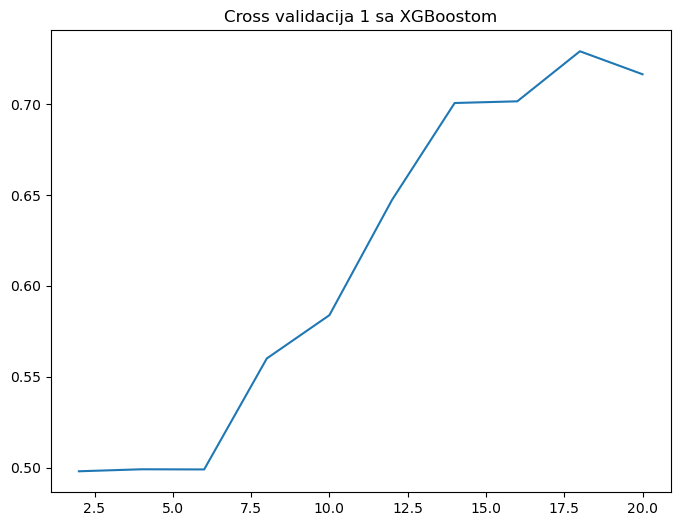

In [185]:
f1_scores= []
for i in range(0, 10):
    cols=sortirane_znacajke[:(i*2+1)]
    results=cross_validation_XGB_1(train, 5, cols)
    f1_scores.append(results.average.mean())
    
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21, 2), f1_scores)
plt.title('Cross validacija 1 sa XGBoostom')
plt.show()

Izgleda kao da model najbolje radi sa 18 znacajki.

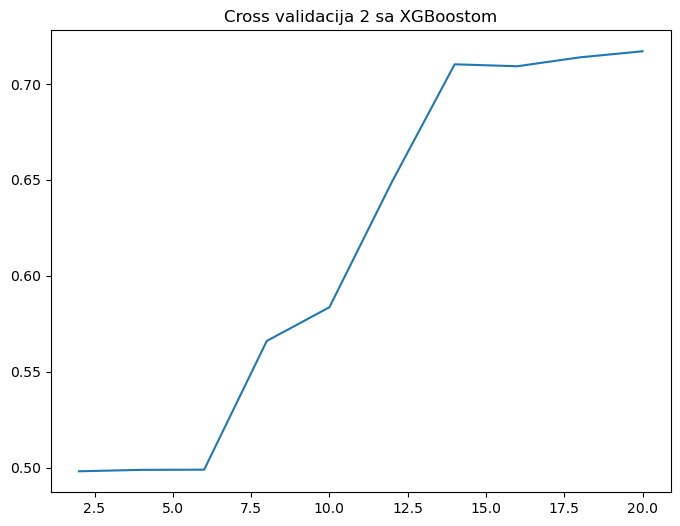

In [163]:
f1_scores= []
for i in range(0, 10):
    cols=sortirane_znacajke[:(i*2+1)]
    results=cross_validation_XGB_2(train, 5, cols)
    f1_scores.append(results.average.mean())
plt.figure(figsize=(8, 6))
plt.plot(range(2, 21, 2), f1_scores)
plt.title('Cross validacija 2 sa XGBoostom')
plt.show()

Ova cross validacija pokazuje da bi trebali koristiti 14 značajki pa ćemo to u sljedečem zadatku i raditi jer smatram da je ta cross validacija bolja.

# 8. Run cross validations with selected features

In [22]:
drop_features=sortirane_znacajke[18:]
train_selected=train.drop(drop_features, axis=1)
results=cross_validation_1(train_selected, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.5233032447628008,0.595613212520837,0.5287395400609962,0.5682359286416826,0.5985863276046203,0.5628956507181874
1,LogisticRegresion,0.5254111642063158,0.5331584941995381,0.5382253876058011,0.6619542808634489,0.5425574567650647,0.5602613567280337
2,RIPPER,0.5617925863044708,0.6286294121760031,0.6274142825436423,0.6199481907112834,0.6744326199821831,0.6224434183435166
3,RandomForrestClassifier,0.5673855699001674,0.7149212031073411,0.6418180871692198,0.8874382944662007,0.7211079145112129,0.7065342138308284
4,ExtraTreesClassifier,0.5866268777694491,0.6795084002118317,0.5704805560457509,0.8740517046280343,0.6829013535174672,0.6787137784345066
5,XGBClassifier,0.6140382925134535,0.7323296773604513,0.6976418883647947,0.8107431238936557,0.73979689598542,0.7189099756235551


Najbolji rezultat daje XGBoost sa f1_score=0.719

In [112]:
drop_features=sortirane_znacajke[18:]
train_selected=train.drop(drop_features, axis=1)
test_selected=test.drop(drop_features, axis=1)
clf=XGBClassifier()
submit(train, test, clf)

Rezultat na test skupu je 0.54485

In [24]:
drop_features=sortirane_znacajke[14:]
train_selected=train.drop(drop_features, axis=1)
results=cross_validation_2(train_selected, 5)
results.head(6)

,algorithm,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,average
0,Gaussian_NB,0.5239663050160334,0.5944764578999334,0.5282016699235711,0.5689489496247669,0.5987587586374954,0.56287042822036
1,LogisticRegresion,0.5242241731318905,0.5880383433149889,0.5352544652414155,0.6640269196219242,0.5276601743164866,0.5678408151253411
2,RIPPER,0.5790553148054007,0.6411910468833399,0.6152974725575218,0.6252687517861033,0.6925986384747433,0.6306822449014218
3,RandomForrestClassifier,0.5736812834555046,0.7125251946840256,0.6376721984881657,0.885659493793107,0.7177151896231508,0.7054506720087907
4,ExtraTreesClassifier,0.5688116364098237,0.6833670414837849,0.5855772666889569,0.8703681912853158,0.6645307403044581,0.6745309752344679
5,XGBClassifier,0.5948931973601629,0.7371622503430078,0.6959413399260943,0.8625216226278875,0.7230083294207661,0.7227053479355836


Bolji je XGBoost sa 14 znacajki.

In [115]:
drop_features=sortirane_znacajke[14:]
train_selected=train.drop(drop_features, axis=1)
test_selected=test.drop(drop_features, axis=1)
clf=XGBClassifier()
submit(train, test, clf)

Rezultat na test skupu je 0.54485

# 9. Explainability with SHAP


In [30]:
clf=XGBClassifier()
train_x=train.drop(["label", 'machine_name', 'day'], axis=1)
train_y=train["label"]
train_x=np.asarray(train_x)
train_y=np.asarray(train_y)
clf.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [31]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_x)

In [36]:
znacajke=(train.drop(["label", 'machine_name', 'day'], axis=1).columns)
features={}
for i in range(len(znacajke)):
    name="feature_"+str(i)
    features[name]=znacajke[i]

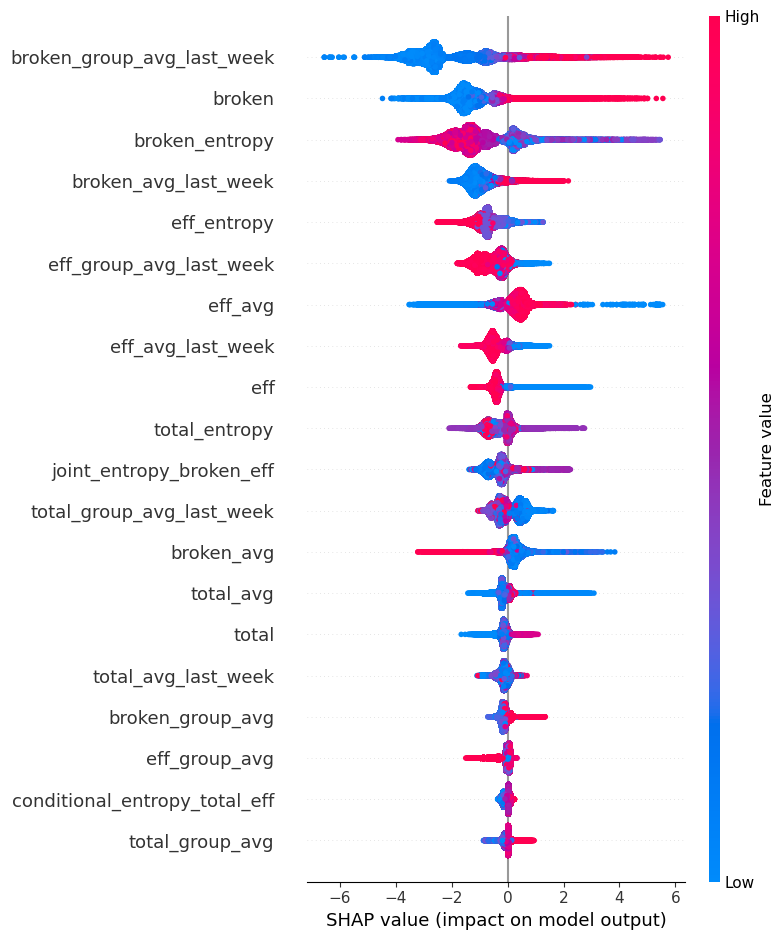

In [39]:
shap.summary_plot(shap_values, train_x,feature_names=znacajke)

In [106]:
grouped = train.groupby('machine_name').agg({'label': 'sum'})
result = grouped.loc[grouped['label'] >= 5].index.tolist()
masina_anomalija=result[3]
dan_anomalije=train.loc[(train['machine_name']==masina_anomalija) & (train['label']==1)].day.min()
samples=train.loc[(train['machine_name']==masina_anomalija) & (train['day']>=dan_anomalije-5)]
samples=samples.drop(["label", 'machine_name', 'day'], axis=1)

In [110]:
sample_pred=clf.predict(sample)
sample_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [107]:
shap.initjs()
%matplotlib inline

shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[0,:])

In [94]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[1,:])

In [95]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[2,:])

In [96]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[3,:])

In [97]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[4,:])

In [98]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[5,:])

In [99]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[7,:])

In [100]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[8,:])

In [101]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[9,:])

In [102]:
shap.force_plot(explainer.expected_value, shap_values[0,:],samples.iloc[10,:])

Njaveci utjecaj na odluku imaju broke_avg, eff_avg i broken_group_avg_last_week. Algoritam nije dobro predvidio anomalije jer je za sve predvidio da će biti 0.

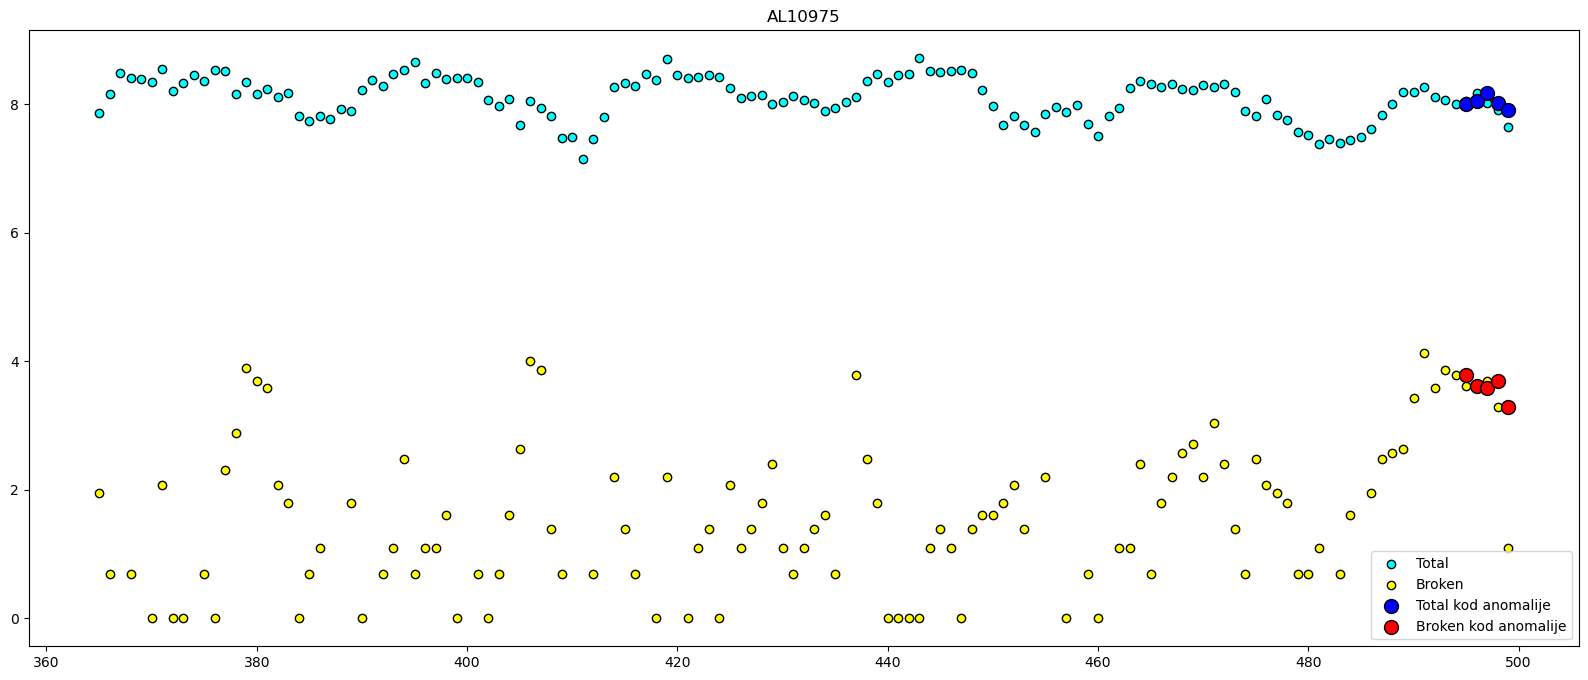

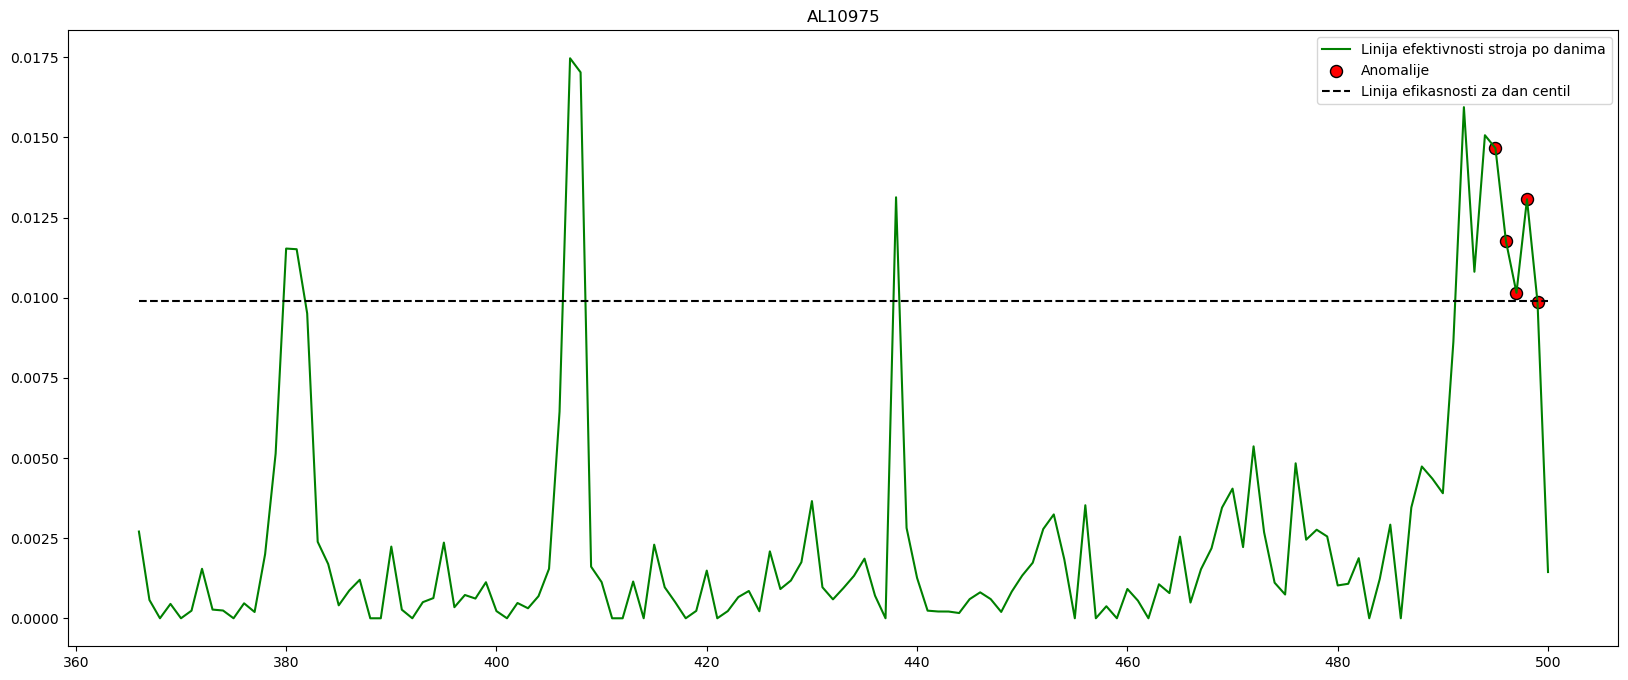

In [125]:
def getAnomalyLine(centil):
    eff_1=[]
    anomalije=train.loc[(train['label']==1)]

    for index, row in anomalije.iterrows():
        eff_1.append(row['broken']/row['total'])
    
    num_to_drop = int(len(eff_1) * centil)
    eff_1.sort()
    eff_1 = eff_1[num_to_drop:]
    
    return eff_1[0]

    

def visualizeEff(machine_name, centil):    
    machine_data=train.loc[(train['machine_name']==machine_name) & (train['day']>364)]
    plt.figure(figsize=(20, 8))
    anomalyLine=getAnomalyLine(centil)
    
    eff= []
    dani_anomalija= []
    anomalija_eff=[]
    line=[]
    dani=[]
    for index, row in machine_data.iterrows():
        eff.append(row['broken']/row['total'])
        line.append(anomalyLine)
        dani.append(row['day'])
        if row['label']==1:
            dani_anomalija.append(row['day'])
            anomalija_eff.append(row['broken']/row['total'])

    plt.title(machine_name)
    plt.plot(dani, eff, 'g-', label="Linija efektivnosti stroja po danima")
    plt.scatter(dani_anomalija, anomalija_eff, c='r', edgecolors= "black", s=75, label='Anomalije')
    plt.plot(dani, line, 'k--', label='Linija efikasnosti za dan centil')
    plt.legend(loc='best')
    plt.show()
    return

def visualizeData(machine_name):    
    machine_data=train.loc[(train['machine_name']==machine_name) & (train['day']>364)]
    plt.figure(figsize=(20, 8))
    
    total= []
    broken=[]
    anomalija_day=[]
    anomalija_total=[]
    anomalija_broken=[]
    for index, row in machine_data.iterrows():
        total.append(row['total'])
        broken.append(row['broken'])
        
        if row['label']==1:
            anomalija_total.append(row['total'])
            anomalija_broken.append(row['broken'])
            anomalija_day.append(row['day'])
        

    plt.title(machine_name)
    plt.scatter(range(365,365+len(total)), np.log(total), c='cyan', edgecolors= "black", label='Total')
    plt.scatter(range(365,365+len(broken)), np.log(broken), c='yellow',edgecolors= "black", label='Broken')
    
    plt.scatter(anomalija_day, np.log(anomalija_total), c='b', s=100, edgecolors= "black", label='Total kod anomalije')
    plt.scatter(anomalija_day, np.log(anomalija_broken), c='r', s=100, edgecolors= "black", label='Broken kod anomalije')
    
    plt.legend(loc='best')
    plt.show()
    return

visualizeData(masina_anomalija)
visualizeEff(masina_anomalija, 0.5)

# 10. Ripper optimization

In [119]:
X=train.drop(["label", 'machine_name', 'day'], axis=1)
y=train["label"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
ripper_clf = lw.RIPPER()
ripper_clf.fit(train_x, train_y)
y_pred=ripper_clf.predict(test_x)
f1_ripper=f1_score(test_y, y_pred, average='macro')
print("F1_score za ripper:"+str(f1_ripper))
print(ripper_clf.ruleset_)

F1_score za ripper:0.9020135492456293
[[broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff=<0.9948^eff_group_avg_last_week=<0.9942^eff_below_avg=1^joint_entropy_broken_eff=>1.24^broken_avg_last_week=>6.29] V [broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff=<0.9948^joint_entropy_broken_eff=0.94-1.05^broken_group_avg=2.354344367980957] V [broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff_below_avg=1^eff_group_avg_last_week=<0.9942^broken_entropy=<3.84^days_eff_below_avg_last_week=6^total_group_avg_last_week=3878.97-5404.57] V [broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff_below_avg=1^eff_group_avg_last_week=<0.9942^broken_entropy=<3.84^days_eff_below_avg_last_week=7] V [broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff_below_avg=1^eff_group_avg_last_week=<0.9942^broken_entropy=<3.84^broken_avg=3.81-7.23^broken_avg_last_week=>6.29] V [broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681^eff_below_avg=1^eff_group_avg_last_week=<0.99

F1_score=0.90, a pravila su razne nejednađbe koje korsite vrijednosti značajki kao faktore potenciranja.

In [129]:
X=train.drop(["label", 'machine_name', 'day'], axis=1)
y=train["label"]
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.33, random_state=42)
ripper_clf = lw.RIPPER()

param_grid = {
    'k': [1, 5, 10],
    'prune_size': [0.1, 0.3, 0.5],
    'dl_allowance': [0.1, 0.5, 1.0],
}


grid_search = GridSearchCV(
    ripper_clf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1
)

grid_search.fit(train_x, train_y)

print('Best Hyperparameters:', grid_search.best_params_)
print('Validation Accuracy:', grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'dl_allowance': 0.5, 'k': 10, 'prune_size': 0.1}
Validation Accuracy: 0.7299708589696914


Preciznost na validate skupu je 0.7299

In [130]:
ripper_best = lw.RIPPER(
    k=grid_search.best_params_['k'],
    prune_size=grid_search.best_params_['prune_size'],
    dl_allowance=grid_search.best_params_['dl_allowance'],
)

ripper_best.fit(train_x, train_y)
y_pred = ripper_best.predict(val_x)
print('F1 score:', f1_score(val_y, y_pred))

F1 score: 0.7258485639686684


Za te parametre F1 score: 0.7258485639686684

In [151]:
clf = lw.RIPPER(
    k=10,
    prune_size=0.1,
    dl_allowance=0.5
)
submit(train, test, clf)

RIPPER algoritam daje lošije predikcije od ostalih algoritama iako je optimiziran grid_searchom. Rezultat nad test skupom je f1=0.5088.

In [127]:
X=train.drop(["label", 'machine_name', 'day'], axis=1)
y=train["label"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
ripper_clf = lw.RIPPER(max_rules=3, max_rule_conds=2)
ripper_clf.fit(train_x, train_y)
y_pred=ripper_clf.predict(test_x)
f1_ripper=f1_score(test_y, y_pred, average='macro')
print("F1_score za ripper:"+str(f1_ripper))
print(ripper_clf.ruleset_)

F1_score za ripper:0.6164873225062208
[[broken_group_avg_last_week=>6.43^eff_entropy=<5.0751681] V [broken_group_avg_last_week=>6.43^broken_entropy=3.84-4.1] V [broken=>6.0^joint_entropy_broken_eff=0.86-0.94]]


Ovako dobijemo samo 3 pravila koja su puno kraća, mjenjaje tih parameta moze sprijeciti prenaučenost.